# Image Classification with PyTorch: Simple CNN 

[Pablo Carballeira] (http://dymas.ii.uam.es/webvpu/gti/user/186/), Escuela Politecnica Superior, Universidad Autónoma de Madrid.

Parts of this code have been adapted from then work of Kevin McGuinness (http://www.eeng.dcu.ie/~mcguinne/), School of Electronic Engineering, Dublin City University, and the work of Ben Trevett (https://github.com/bentrevett), Heriot-Watt University

You can find documentation about working in Colab here (https://colab.research.google.com/notebooks/intro.ipynb)


---

In this lab assignment you will learn how to use the [PyTorch](https://pytorch.org/) deep learning framework to create and train a simple deep learning model for handwritten digit classification. You will also learn about data loaders and datasets in PyTorch and how to track model training progress.


## Instructions

Anywhere you see a **???** in the code below, fill in in with the correct code.

# Import packages

Find the PyTorch docs at https://pytorch.org/docs/stable/index.html 

Tutorials: https://pytorch.org/tutorials/

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
# import torch.utils.data as data

import torchvision.datasets as datasets
from torchvision.datasets import MNIST
from sklearn.cluster import KMeans

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import copy
import random
import time

# Enable GPU acceleration

Open to the Edit menu and select *Notebook settings* and check that *GPU* is selected under hardware accelerator.


In [ ]:
# make sure to enable GPU acceleration!
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


We set the random seed so all of our experiments can be reproduced.

In [ ]:
# Set random seed for reproducability

SEED = 1234

torch.manual_seed(SEED)
np.random.seed(SEED)

random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Specify a model architecture

We will use this simple CNN with two conv layers, one pooling layer, two fully connected, and some dropout.

![Model Architecture](http://www.eeng.dcu.ie/~mcguinne/media/cnn.png)

In [ ]:
class SimpleCNN(nn.Module):

    def __init__(self, num_channels=1, num_classes=10):
        super(SimpleCNN, self).__init__()

        # create the first convolution layer (bottom of the diagram)
        self.conv1 = nn.Conv2d(num_channels, 32, 3, stride=1, padding=1)

        # create the second convolution layer
        self.conv2 = nn.Conv2d(32, 32, 3, stride=1, padding=1)

        # create the 2x2 max pooling layer
        self.pool1 = nn.MaxPool2d(2)

        # create the dropout operation with p = 0.25
        self.drop1 = nn.Dropout(p=0.25)
        
        # create a fully connected layer mapping the output of the pooling layer to 128 dimensions. 
        # Use nn.Linear 
        self.fc1 = nn.Linear(14*14*32, 128)
        
        # create the second dropout operation with p = 0.5
        self.drop2 = nn.Dropout(p = 0.5)
        
        # create the final fully connected layer mapping 128 dimensions to 10 classes
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, X):

        # apply conv1 and a relu
        X = F.relu(self.conv1(X))

        # apply conv2 and a relu
        X = F.relu(self.conv2(X))

        # apply the pooling layer and dropout with p=0.25
        X = self.pool1(X)
        X = self.drop1(X)

        # flatten the spatial features. You can use the reshape() function for this
        X = nn.Flatten()(X)

        # apply the first fully connected layer and a relu
        X = F.relu(self.fc1(X))
        
        # apply dropout with p = 0.5
        X = self.drop2(X)
        
        interm_features = X # we will use this output for an intermedeate representation of the network 

        # apply the final fully connected layer
        X = self.fc2(X)
        
        # return the logits (pre-softmax activations)
        return X, interm_features 

# Load the datasets

Here, we will download and prepare the MNIST dataset. For that, we need to specify a **transform** to convert images to torch tensors.

We are adding a **normalization** transform here too so that the images have mean zero and unit variance. This is optional. For some problems (models/datasets) proper normalization is important for performance. For others (e.g. models with batch normalization early on), the importance of normalization is less.

PyTorch comes with a built-in dataset class for the MNIST digit classification task in the ``torchvision`` package. It also has built-in for other common datasets and tasks like CIFAR-10 and ImageNet. See: https://pytorch.org/docs/stable/torchvision/datasets.html


In [ ]:
# transform for the training data
# normalization uses mean and std values of the training data
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.1307], [0.3081]) # normalization coefficients are precomputed
])

# use the same transform for the validation data
valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.1307], [0.3081]) # normalization coefficients are precomputed
])

# load train data, downloading if needed
train_set = MNIST('./data/mnist', train=True, download=True, 
                  transform=train_transform)
# load validation data, downloading if needed
valid_set = MNIST('./data/mnist', train=False, download=True, 
                  transform=valid_transform)



Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw




Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw




Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
print(f'train set is', ' x '.join(str(x) for x in train_set.data.shape))
print(f'valid set is', ' x '.join(str(x) for x in valid_set.data.shape))

train set is 60000 x 28 x 28
valid set is 10000 x 28 x 28


## Some notes about the training data

There are two subsets of the data being used here:

- **Training data** Data that is used to optimize model parameters
- **Validation data** Data that is used for model selection (choosing hyperparameters).

The data that we use to monitor the training progress is the validation data, since it can be used to tune the model architecture (number of layers, etc) and other hyperparameters.

Usually, we would keep another separate **test set** for testing the final model in order to get an unbiased estimate of *out of sample* accuracy. Unfortunately, MNIST doesn't have a separate test set and it is common practice on this task to use the validation set both for validation and test. **Warning**: This is considered BAD PRACTICE in most situations!




# Preview the data

Let's look at a sample of the training data. Here we'll use some indexing tricks (reshaping and permuting axes) to put the first 64 digits in the dataset into a grid.

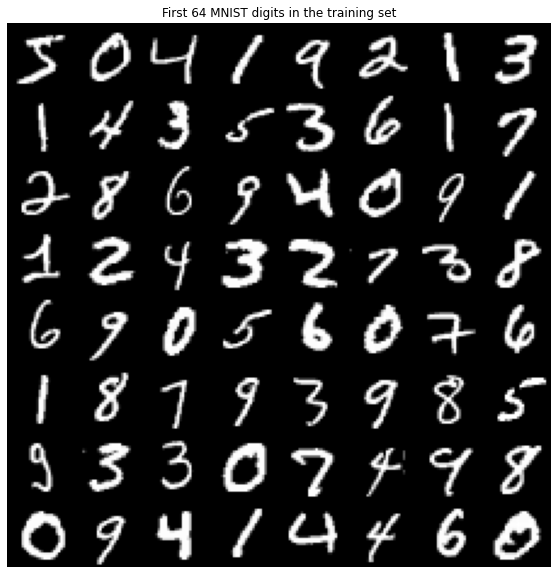

Labels: [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7 3 8 6 9 0 5 6
 0 7 6 1 8 7 9 3 9 8 5 9 3 3 0 7 4 9 8 0 9 4 1 4 4 6 0]


In [ ]:
# grab the first 64 samples from the training set
sample = train_set.data[:64]

# sample shape is (64, 28, 28), but we would like a grid of 8x8 images, each of size 28x28.
# this would mean an image with width and height of 8*28. How do we go from a (64, 28, 28)
# image to one of size (8*28, 8*28)?

# start by splitting the first dimension (64) int 8 x 8
sample = sample.reshape(8, 8, 28, 28)

# the shape is now (8, 8, 28, 28). Next, move the second dimension to the third position
sample = sample.permute(0, 2, 1, 3)

# the shape is now (8, 28, 8, 28). Finally, collapse the first-second and third-forth
# dimensions into one.
sample = sample.reshape(8*28, 8*28)

# Voila! the shape is (8*28, 8*28). Note that we can't just reshape to this shape immediately,
# because the dimension permute in step two above is also needed.

# Show the images
plt.figure(figsize=(10,10))
plt.imshow(sample)
plt.axis('off')
plt.title('First 64 MNIST digits in the training set')
plt.gray()
plt.show()

print('Labels:', train_set.targets[:64].numpy())

# Setup the data loaders

PyTorch provides a [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) class in `torch.utils.data` that can be used to manage loading data from datasets using multiple worker threads and packaging data into datasets. It also provides data **shuffling** and **sampling** strategies.

Having multiple threads to load the data improves the performance when training larger models on large datasets since the CPU threads can be busy loading and transforming data while the GPU is doing forward and backward propagation.


**Note**: The `Dataset` and `DataLoader` classes are not mandatory in PyTorch; you can write your own data loading mechanisms. 

In [ ]:
train_loader = DataLoader(train_set, batch_size=256, num_workers=0, shuffle=True)

# create a similar data loader for the validation set, but turn off shuffling
# (it is unnecessary to shuffle validation data) and make the batch size 512
valid_loader = DataLoader(valid_set, batch_size=512, num_workers=0, shuffle=False)

# Instantiate the model

Create an instance of the model and move it (memory and operations) to the CUDA device.

In [ ]:
model = SimpleCNN()
model.to(device)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=6272, out_features=128, bias=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Let's count the total number of parameters in our model.

In [ ]:
def count_parameters(model):
    total = 0
    for p in model.parameters():
        
        # compute the total parameters in the layer
        # which is equal to the product of the dimensions
        # in p.shape (np.prod may be helpful)
        layer_count = np.prod(p.shape)
        total += layer_count
        
    return total


print(f'The model has {count_parameters(model)} parameters')

The model has 813802 parameters


# Train the model

We're almost ready to train the model!

Each pass through the training loop is called an *epoch* (an epoch is when every training example has been seen once). 

It's a good idea to save a snapshot (or *checkpoint*) of the model and the optimizer after every epoch. Let's setup some helpers to do this

In [ ]:
# we will save checkpoints to the checkpoints folder. Create it.
!mkdir -p checkpoints

In [ ]:
def save_checkpoint(optimizer, model, epoch, filename):
    checkpoint_dict = {
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
        'epoch': epoch
    }
    torch.save(checkpoint_dict, filename)


def load_checkpoint(optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict['epoch']
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    return epoch

Let's code up the training loop as a function. There are two parts to the loop:
- **Train phase**: where batches of data are loaded from the training set and the model parameters are optimized using backpropagation to compute gradients.
- **Validation phase**: where batches of data are loaded from the validation set and out of sample error is estimated using this data.

In [ ]:
# create the criterion to optimize (the loss function). This is a multi-class classification 
# problem, so categorical cross entropy is an appropriate loss.
# it also applies the softmax activation function
# criterion = ??
criterion = nn.CrossEntropyLoss()

# create an SGD optimizer with learning rate 0.01, momentum 0.9, and nesterov momentum turned on
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov = True)

def train_for_epoch():

    # put model in train mode
    model.train()

    # keep track of the training losses during the epoch
    train_losses = []

    for batch, targets in train_loader:

        # Move the training data to the GPU
        batch = batch.to(device)
        targets = targets.to(device)
        
        # clear previous gradient computation
        optimizer.zero_grad()

        # forward propagation
        predictions, interm_feats = model.forward(batch)
        
        # calculate the loss for the batch
        loss = criterion(predictions, targets)
        
        # backpropagate to compute gradients
        loss.backward()

        # update model weights
        optimizer.step()

        # update the array of batch losses
        train_losses.append(loss.item())

    # calculate average training loss of the epch
    train_loss = np.mean(train_losses)
        
    return train_loss


def validate():

    # put model in evaluation mode
    model.eval()

    # keep track of losses and predictions
    valid_losses = []
    y_pred = []

    # We don't need gradients for validation, so wrap in 
    # no_grad to save memory
    with torch.no_grad():

        for batch, targets in valid_loader:

            # Move the validation batch to the GPU
            batch = batch.to(device)
            targets = targets.to(device)

            # forward propagation
            predictions, interm_feats = model(batch)

            # calculate the loss
            loss = criterion(predictions, targets)

            # update running loss value
            valid_losses.append(loss.item())

            # save predictions
            y_pred.extend(predictions.argmax(dim=1).cpu().numpy())

    # compute the average validation loss
    valid_loss = np.mean(valid_losses)

    # Collect predictions into y_pred and ground truth into y_true
    y_pred = np.array(y_pred, dtype=np.float32)
    y_true = np.array(valid_set.targets, dtype=np.float32)

    # Calculate accuracy as the average number of times y_true == y_pred
    accuracy = np.mean(y_pred == y_true)

    return valid_loss, accuracy


def train(first_epoch, num_epochs):
    
    train_losses, valid_losses = [],  []

    for epoch in range(first_epoch, first_epoch + num_epochs):

        # training phase
        train_loss = train_for_epoch()

        # validation phase
        valid_loss, valid_acc = validate()        

        print(f'[{epoch:03d}] train loss: {train_loss:04f}  '
              f'val loss: {valid_loss:04f}  '
              f'val acc: {valid_acc*100:.4f}%')
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        # Save a checkpoint
        checkpoint_filename = f'checkpoints/mnist-{epoch:03d}.pkl'
        save_checkpoint(optimizer, model, epoch, checkpoint_filename)
    
    return train_losses, valid_losses

Train the model for 10 epochs using the functions we have defined



In [ ]:
train_losses, valid_losses = train(1, 10) 

[001] train loss: 0.523658  val loss: 0.162849  val acc: 95.3100%
[002] train loss: 0.230095  val loss: 0.095466  val acc: 97.0900%
[003] train loss: 0.149448  val loss: 0.060607  val acc: 97.9500%
[004] train loss: 0.113399  val loss: 0.049437  val acc: 98.3900%
[005] train loss: 0.092953  val loss: 0.042657  val acc: 98.6000%
[006] train loss: 0.078461  val loss: 0.038975  val acc: 98.6600%
[007] train loss: 0.070092  val loss: 0.036412  val acc: 98.7800%
[008] train loss: 0.063479  val loss: 0.033044  val acc: 98.9300%
[009] train loss: 0.059240  val loss: 0.030349  val acc: 98.9200%
[010] train loss: 0.056324  val loss: 0.029563  val acc: 98.9800%


# Plot the learning curves

Here we plot the learning curves after training. Note that you can also use [Tensorboard](https://www.tensorflow.org/guide/summaries_and_tensorboard) with PyTorch in Google Colab 


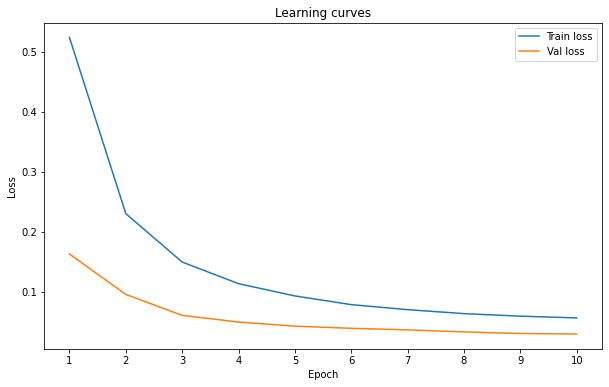

In [ ]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10,6))
# use matplotlib to plot the training and validation losses in a single graph,
# and label them accordingly
plt.plot(epochs, train_losses, label = "Train loss")
plt.plot(epochs, valid_losses, label = "Val loss")

plt.legend()
plt.title('Learning curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.show()

# Error analysis

Here we will take a look at the validation samples that the model got wrong. This is often a good idea when trying to improve a models, since it gives you some intuition about the kinds of examples the model finds difficult, which can lead to insights on how to improve models.

We'll examine our model by: plotting a confusion matrix, seeing which incorrect examples our model was most confident about, view our model's learned representations in two dimensions with t-SNE, and take a look at the weights of our model.

First, we'll define a function to fet the model's predictions across a dataset training/valid/test that alos provides other outputs

## Predictions of the model in the validation set

We start by defining a predict function which takes a data loader and produces predictions for all samples.

In addition to the predictions, this function also provides other useful outputs

The predictions here are a categorical distribution over the 10 different digits, which means that each prediction has dimension 10. We can recover the label for which the model is most confident by taking an $\arg\max$ over the predicted distribution.

In [ ]:
def get_predictions(model, iterator, device):

    model.eval()

    # save the predictions, images and labels in this list
    y_preds = []
    images = []
    labels = []
    
    with torch.no_grad():

        for batch, targets in iterator:
            batch = batch.to(device)
            # predict probabilities of each class
            predictions, _ = model(batch)
            # apply a softmax to the predictions
            predictions = nn.Softmax(dim = 1)(predictions)
            
            # top_pred = y_preds.argmax(1, keepdim = True)

            # save
            images.append(batch.cpu())
            labels.append(targets.cpu())
            y_preds.append(predictions.cpu())

    # stack
    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    y_preds = torch.cat(y_preds, dim = 0)

    return images, labels, y_preds

In [ ]:
# compute predictions on the validation set
# images, labels, probs =
images, labels, probs = get_predictions(model, valid_loader, device)

# ...and then get the predicted labels from the model's predictions. Use torch.argmax
pred_labels = torch.argmax(probs, dim = 1)

In [ ]:
# convert to numpy
y_true = np.array(labels)
y_pred = np.array(pred_labels)

# calculate the number of errors
num_errors = np.sum(y_true != y_pred)

print(f'Validation errors {num_errors} (out of {len(valid_set)})')

Validation errors 102 (out of 10000)


## Confusion matrix
 
We'll examine our model by plotting a confusion matrix, which helps us understand which classes the model is more frequently mixing

In [ ]:
def plot_confusion_matrix(labels, pred_labels):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    # use the confusion_matrix and ConfusionMatrixDisplay functions
    # from sklearn.metrics to display the confusion matrix
    cm = confusion_matrix(labels, pred_labels, labels = np.unique(labels), normalize = "true")
    print(np.argmax(cm))
    cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = np.unique(labels))
    cm.plot(cmap = 'Blues', ax = ax)

11


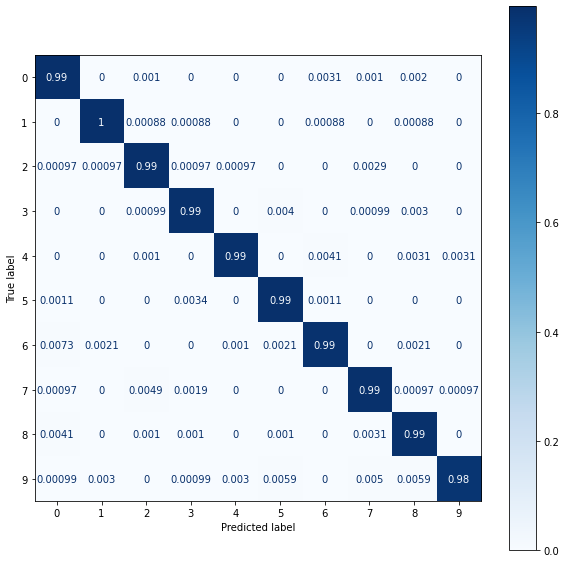

In [ ]:
plot_confusion_matrix(labels, pred_labels)

## Analysis of samples predicted wrongly
Here we will find the samples that the model is predicting wrongly and we will. Especifically, we will look at those samples that the model is predicting wrongly with a high score for the wrong class

Find out if each sample is correctly or wrongly predicted

In [ ]:
# you can use torch.eq
corrects = torch.eq(labels, pred_labels)

Then, get all of the incorrect examples and sort them by descending confidence in their prediction.

In [ ]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

We can then use this to plot the examples the model got wrong and was most confident about.

In [ ]:
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap = 'bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

Most of the mistakes look pretty reasonable as most of the digits shown are a bit off. Models are trained to be  incredibly confident with its predictions, so it's not unreasonable for it to be incredibly confident when they are wrong.

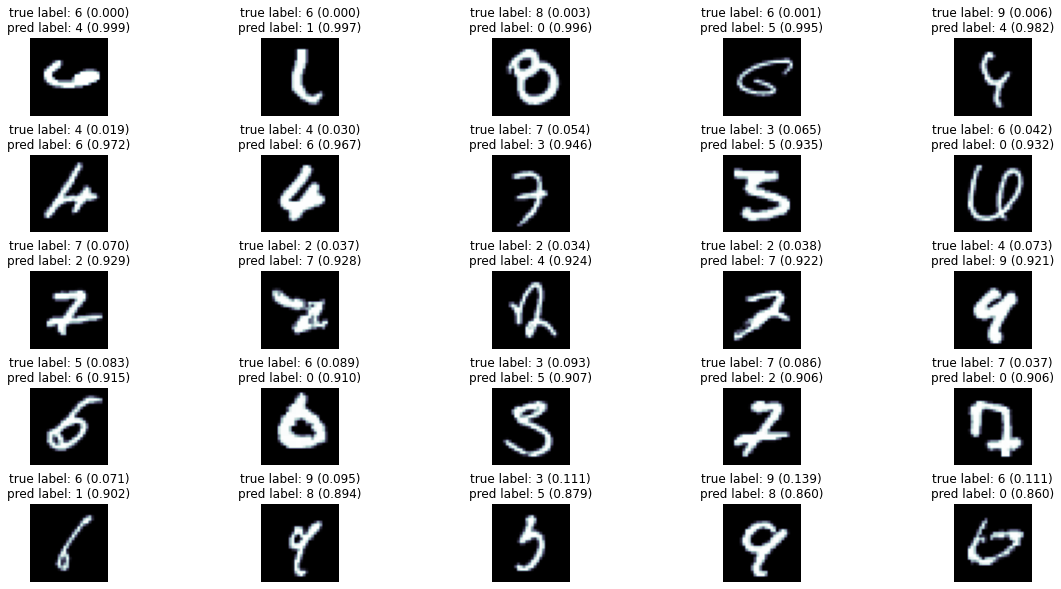

In [ ]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)

# T-SNE representations: final and intermediate layer

Let's move on to plotting the model's representations in lower dimensions so we can visualize them.

We will use the t-Distributed Stochastic Neighbor Embedding (t-SNE) technique to do this. It is a very useful dimensionality reduction techinque for the visualization of high-dimensional datasets (as it happens with the representations of a CNN). You can find more information about t-SNE here: (https://lvdmaaten.github.io/tsne/)

First, we'll get the representations (features) from the model...



In [ ]:
def get_representations(model, iterator, device):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)

            y_pred, interm_feats = model(x)

            outputs.append(y_pred.cpu())
            intermediates.append(interm_feats.cpu())
            labels.append(y)
        
    outputs = torch.cat(outputs, dim = 0)
    intermediates = torch.cat(intermediates, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, intermediates, labels
    # return outputs, labels

In [ ]:
outputs, intermediates, labels = get_representations(model, valid_loader, device)

Now, let's define the functions to get the t-SNE representations in two dimensions and plot them.

In [ ]:
def get_tsne(data, n_components = 2, n_images = None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

In [ ]:
def plot_representations(data, labels, n_images = None, legend = True):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'tab10')
    if legend:
      handles, labels = scatter.legend_elements()
      legend = ax.legend(handles = handles, labels = labels)

Let's plot the t-SNE representations for a set of validation images. We will first plot the t-SNE representations of the outputs of the network

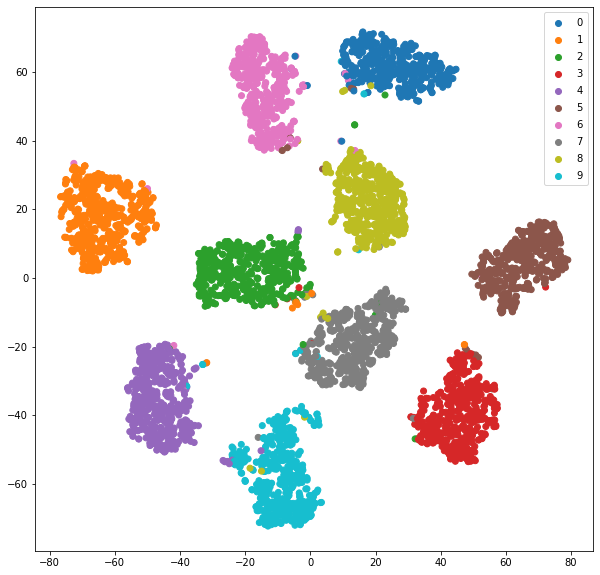

In [ ]:
N_IMAGES = 5000

output_tsne_data = get_tsne(outputs, n_images = N_IMAGES)
plot_representations(output_tsne_data, labels, n_images = N_IMAGES)

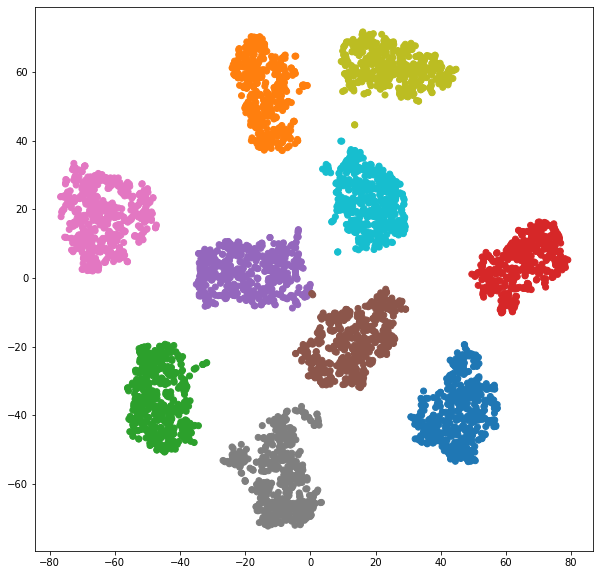

In [ ]:
km = KMeans(10)
pred = km.fit_predict(output_tsne_data, labels)
plot_representations(output_tsne_data, pred, n_images = N_IMAGES, legend = False)

Each of the colors represent the samples that belong to one class (ground truth label). The samples grouped in a cluster present features that are categorized by the network as belonging to the same class (most predictions will be correct). Cluster density and distancing reflect the capacity of the network to correctly identify samples from different classes. 

Now let's check if intermediate representations would be enough to  obtain a correct classification of validation samples

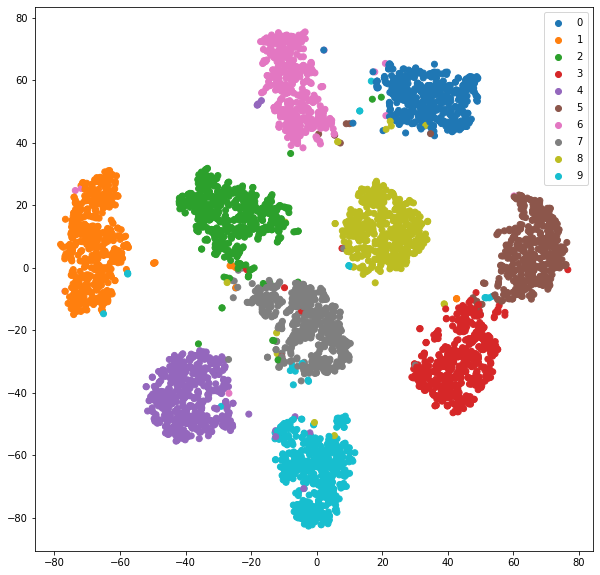

In [ ]:
intermediate_tsne_data = get_tsne(intermediates, n_images = N_IMAGES)
plot_representations(intermediate_tsne_data, labels, n_images = N_IMAGES)

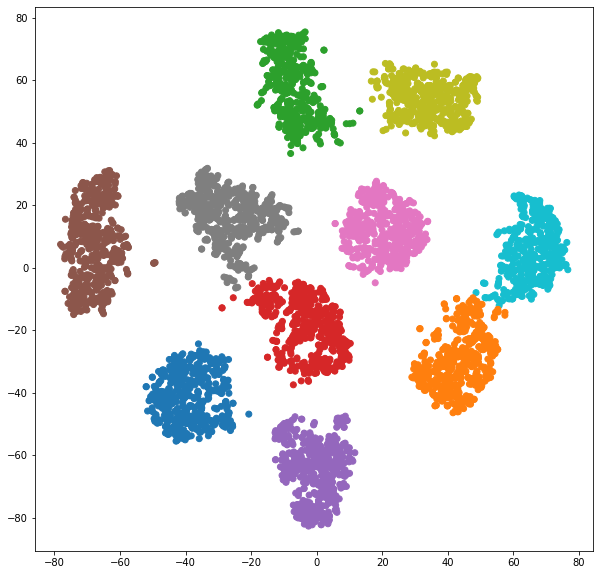

In [ ]:
# KMeans representation
km = KMeans(10)
pred = km.fit_predict(intermediate_tsne_data, labels)
plot_representations(intermediate_tsne_data, pred, n_images = N_IMAGES, legend = False)

# Resuming training

Let's load up the final model and resume training to see how far we can push up the accuracy.

In [ ]:
ls checkpoints

mnist-001.pkl  mnist-003.pkl  mnist-005.pkl  mnist-007.pkl  mnist-009.pkl
mnist-002.pkl  mnist-004.pkl  mnist-006.pkl  mnist-008.pkl  mnist-010.pkl


In [ ]:
# Load the checkpoint corresponding to the 10th epoch
epoch = epochs[-1] - 1
load_checkpoint(optimizer, model, f'checkpoints/mnist-{epoch:03d}.pkl')

print('Resuming training from epoch ', )

Resuming training from epoch 


In [ ]:
# Resume training from the 10th epoch
# train for 10 more epochs
train_losses, valid_losses = train(11, 10)

[011] train loss: 0.054529  val loss: 0.029126  val acc: 99.0600%
[012] train loss: 0.050939  val loss: 0.028509  val acc: 99.0300%
[013] train loss: 0.048594  val loss: 0.027371  val acc: 99.0200%
[014] train loss: 0.043991  val loss: 0.026693  val acc: 99.0800%
[015] train loss: 0.040671  val loss: 0.026391  val acc: 99.1800%
[016] train loss: 0.040112  val loss: 0.024935  val acc: 99.2400%
[017] train loss: 0.037223  val loss: 0.027345  val acc: 99.0900%
[018] train loss: 0.037392  val loss: 0.027784  val acc: 99.1400%
[019] train loss: 0.034823  val loss: 0.026963  val acc: 99.0600%
[020] train loss: 0.034275  val loss: 0.026406  val acc: 99.1700%


Plot the learning curves. 

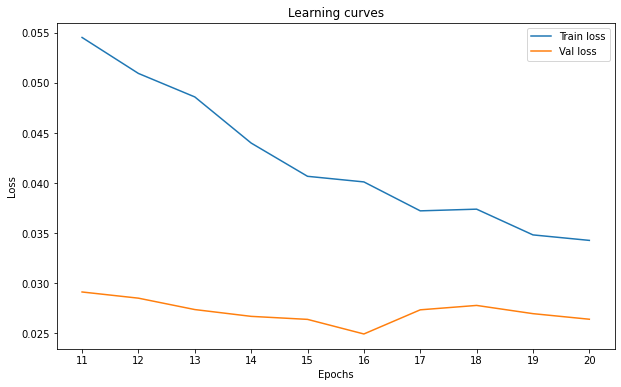

In [ ]:
# Use the previous code
epochs = range(11, 11 + len(train_losses))

plt.figure(figsize=(10,6))
# use matplotlib to plot the training and validation losses in a single graph,
# and label them accordingly
plt.plot(epochs, train_losses, label = "Train loss")
plt.plot(epochs, valid_losses, label = "Val loss")

plt.legend()
plt.title('Learning curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.show()